In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import expected_max_performance
import numpy as np

In [10]:
data = {
    "DilatedCNN-3L(CH)": "../stats/seq_ch_conv_3lv.yaml-2020-05-15--13-36.30.csv",
    "DilatedCNN-3L(CH+SY)": "../stats/seq_sy_ch_conv_3lv.yaml-2020-05-15--22-41.30.csv",
    "UniLSTM(CH)": "../stats/seq_ch_lstm_uni.yaml-2020-05-16--10-14.30.csv",
    "BiLSTM(CH)": "../stats/seq_ch_lstm_bi.yaml-2020-05-16--10-13.30.csv",
    "BiLSTM(CH+SY)": "../stats/seq_sy_ch_lstm_bi.yaml-2020-05-16--17-57.30.csv",
    "BiLSTM(SY)": "../stats/seq_sy_lstm_bi.yaml-2020-05-17--09-44.30.csv",
}

----
seq_ch_conv_3lv Val WL-F1=0.9466 ./artifacts/seq_ch_conv_3lv.yaml-2020-05-15--13-36.30/run-23
CL-f1=0.9684 WL-f1=0.9226
----
seq_sy_ch_conv_3lv Val WL-F1=0.9723 ./artifacts/seq_sy_ch_conv_3lv.yaml-2020-05-15--22-41.30/run-13
CL-f1=0.9800 WL-f1=0.9501
----
seq_ch_lstm Val WL-F1=0.9646 ./artifacts/seq_ch_lstm_bi.yaml-2020-05-16--10-13.30/run-3
CL-f1=0.9748 WL-f1=0.9363
----
seq_sy_ch_lstm Val WL-F1=0.9699 ./artifacts/seq_sy_ch_lstm_bi.yaml-2020-05-16--17-57.30/run-24
CL-f1=0.9780 WL-f1=0.9440
----
seq_sy_lstm Val WL-F1=0.9408 ./artifacts/seq_sy_lstm_bi.yaml-2020-05-17--09-44.30/run-11
CL-f1=0.9684 WL-f1=0.9216


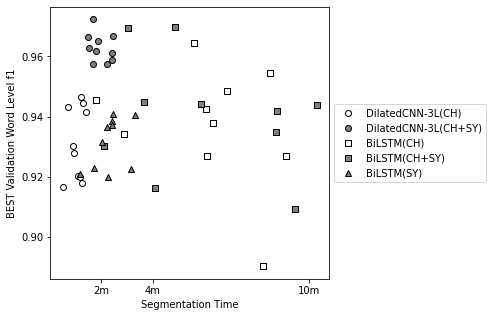

In [65]:
def marker(k):
    if "CNN" in k:
        return "o"
    elif "UniLSTM" in k:
        return "*"
    elif "BiLSTM(SY)" in k:
        return "^"
    elif "BiLSTM" in k:
        return "s"
    
def plot_hyperopt(families, n=10):
    plt.figure(figsize=(5, 5))
    # draw max line
    for k in families:
        df = pd.read_csv(data[k]).sort_values(by="best-val:word_level:f1", ascending=False)[:n]
        
        best_model = df[df["best-val:word_level:f1"] == df["best-val:word_level:f1"].max()].to_dict("row")[0]
        print("----")
#         print(best_model)
        print(best_model["name"], "Val WL-F1=%.4f" % best_model["best-val:word_level:f1"], best_model["best-val:model_path"])
        print("CL-f1=%.4f" % best_model["best-test:char_level:f1"], "WL-f1=%.4f" % best_model["best-test:word_level:f1"])
        plt.scatter(
            df["best-val:time_took"] / 60 , df["best-val:word_level:f1"],
            label=k,
            marker=marker(k),
            edgecolor="black",
            facecolor="gray" if "SY" in k else "white"
        )

    plt.ylabel("BEST Validation Word Level f1")
    plt.xlabel("Segmentation Time")
    plt.xticks([2, 4, 10], ["2m", "4m", "10m"])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
plot_hyperopt(["DilatedCNN-3L(CH)", "DilatedCNN-3L(CH+SY)", "BiLSTM(CH)", "BiLSTM(CH+SY)", "BiLSTM(SY)"], n=10)

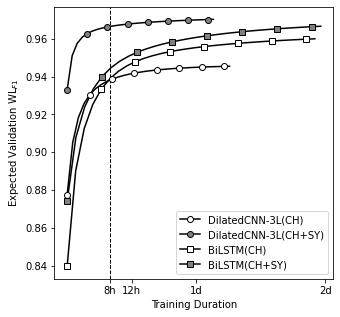

In [56]:
def plot_expected_perf(families):
    plt.figure(figsize=(5, 5))
    plt.axvline(8, ls="--", zorder=0, color="black", lw=1)
    for k in families:
        df = pd.read_csv(data[k])
        exp_perf = expected_max_performance.samplemax(df["best-val:word_level:f1"])
        mean = np.array(exp_perf["mean"])
        std = np.array(exp_perf["var"])
        _min, _max = exp_perf["min"], exp_perf["max"]
        avg_time = (df["training_took"] / (60*60)).mean()
        x = np.arange(0, df.shape[0]) * avg_time
        plt.plot(
            x, 
            exp_perf["mean"],
            marker=marker(k), 
            label=k,
            markevery=4,
            markerfacecolor="gray" if "SY" in k else "white",
            color="black",
            zorder=1 if "CNN" in k else 0
        )
        
#         plt.fill_between(
#             x,
#             np.where(mean - std > _min, mean - std, _min),
#             np.where(mean + std < _max, mean + std, _max),
#             color="gray",
#             alpha=0.2,
#             zorder=0,
#         )
#     plt.ylim(0.8)
    plt.ylabel("Expected Validation WL$_{F1}$")
    plt.xlabel("Training Duration")
    plt.xticks([8, 12, 24, 48], ["8h", "12h", "1d", "2d"])
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend()
    
plot_expected_perf(["DilatedCNN-3L(CH)", "DilatedCNN-3L(CH+SY)",  "BiLSTM(CH)", "BiLSTM(CH+SY)"])
plt.savefig("./figures/expected_val_perf.svg")